In [1]:
import os
import numpy as np
import pandas as pd

In [19]:
import datetime

from time import time
from tqdm import tqdm_notebook as tqdm

In [3]:
from collections import Counter


### Load datasets

In [4]:
train = pd.read_csv('input/data-science-bowl-2019/train.csv')

In [5]:
train_labels = pd.read_csv('input/data-science-bowl-2019/train_labels.csv')

In [6]:
test = pd.read_csv('input/data-science-bowl-2019/test.csv')

In [7]:
specs = pd.read_csv('input/data-science-bowl-2019/specs.csv')

### Filter unusefull data

In [8]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

In [9]:
train.shape

(8294138, 11)

In [10]:
keep_id.shape

(4242, 1)

installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? As you can see below, yes there are 628 of those.

In [11]:
discard_id = train[train.installation_id.isin(train_labels.installation_id.unique()) != True].installation_id.unique()

In [12]:
discard_id.shape

(628,)

In [13]:
train = train[train.installation_id.isin(discard_id)!=True]

In [14]:
train.shape

(7734558, 11)



Basically what we need to do is to compose aggregated features for each session of which we know the train label.

In [15]:
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


### Load datasets

In [16]:
#Credits go to Andrew Lukyanenko

def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

categoricals = ['session_title']

In [17]:
#Credits go to Massoud Hosseinali

def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title] #from Andrew
        
        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1] #from Andrew
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if test_set=True, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in train_set, all assessments are kept
    return all_assessments

#### process Train dataset

In [20]:
#Credits go to Massoud Hosseinali

#The get_data function is applied to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


ImportError: IntProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
#Credits go to Massoud Hosseinali

#Compiled_data is converted into a DataFrame and deleted to save memmory
reduce_train = pd.DataFrame(compiled_data)
del compiled_data
reduce_train.shape

In [ ]:
reduce_train.head()

In [ ]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
reduce_test = pd.DataFrame(new_test)

In [ ]:
reduce_test.shape

In [ ]:
reduce_test.head()

In [ ]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [ ]:
reduce_train.shape

In [ ]:
reduce_test.shape

In [ ]:
reduce_train.index = reduce_train.installation_id.tolist()

In [ ]:
reduce_test.index = reduce_test.installation_id.tolist()

In [ ]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

In [ ]:
y = reduce_train['accuracy_group'].copy()

In [ ]:
cols_to_keep = [c for c in reduce_train.columns if c not in cols_to_drop]

In [ ]:
reduce_train = reduce_train[cols_to_keep]

In [ ]:
reduce_test = reduce_test[cols_to_keep]

### Save datasets

In [26]:
train_features = reduce_train.copy()

In [ ]:
train_labels = y.copy()

In [28]:
test_features = reduce_test.copy()

In [ ]:
del reduce_train, test_features

# LIGHTGBM - REGRESSION - TEST

In [1]:
import lightgbm as lgb


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.utils.multiclass import unique_labels

import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json


from functools import partial
import scipy as sp

from sklearn.base import BaseEstimator, TransformerMixin

### GLOBAL VARIABLES

In [3]:
DATAPATH = 'data/features/'
SEED = 47
NITER = 100
CV = 3
SCORE = 'rmse'
handlingnull = False
NJOBS = 2
USEGPU = False
NCLASS = 0

In [8]:
train_features.shape

(17690, 106)

In [9]:
test_features.shape

(1000, 106)

In [10]:
### create a DMatrix and handling Null values
lgb_train = lgb.Dataset(data=train_features, label=train_labels)

In [11]:
lgb_test = lgb.Dataset(test_features)

### TRAIN MODEL

#### Set hyperparameters

In [12]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
boosting = 'gbdt'


# Learning Task Parameters
# This defines the loss function to be minimized. See documentation
# -  options: regression, regression_l1, huber, fair, poisson, quantile, 
# mape, gamma, tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda,
# lambdarank, aliases: objective_type, app, application
objective  = 'regression'


# The metric to be used for validation data.
# - rmse, root square loss, aliases: root_mean_squared_error, l2_root
# - quantile, Quantile regression
# - mape, MAPE loss, aliases: mean_absolute_percentage_error
# - huber, Huber loss
# - fair, Fair loss
# - poisson, negative log-likelihood for Poisson regression
# - gamma, negative log-likelihood for Gamma regression
# - gamma_deviance, residual deviance for Gamma regression
# - tweedie, negative log-likelihood for Tweedie regression
# - ndcg, NDCG, aliases: lambdarank
# - map, MAP, aliases: mean_average_precision
# - auc, AUC
# - binary_logloss, log loss, aliases: binary
metric = 'rmse'



In [13]:
model = lgb.LGBMRegressor()

In [14]:
model_param = model.get_params()

In [15]:
model_param

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [16]:
model_param['seed'] = SEED
model_param['boosting'] = boosting
model_param['objective'] = objective
#model_param['n_estimator'] = 313
#model_param['scale_pos_weight'] = scale_pos_weight
model_param['nthread'] = 8

In [17]:
early_stopping_rounds = 50

In [18]:
cvresult = lgb.cv(model_param, lgb_train, num_boost_round = 1000, nfold = CV, metrics = metric, early_stopping_rounds = early_stopping_rounds, seed = SEED)

/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [19]:
cvresult = pd.DataFrame(cvresult)

In [20]:
n_estimators = cvresult.shape[0]

In [21]:
model_param['n_estimators'] = n_estimators

In [22]:
model = lgb.train(model_param, lgb_train, )

/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


#### Optimized Rounder

In [23]:
y_pred = model.predict(test_features)

In [24]:
coefficients = [1.2259815 , 1.65019508, 2.25102416]


In [25]:
y_pred[y_pred <= coefficients[0]] = 0
y_pred[np.where(np.logical_and(y_pred > coefficients[0], y_pred <= coefficients[1]))] = 1
y_pred[np.where(np.logical_and(y_pred > coefficients[1], y_pred <= coefficients[2]))] = 2
y_pred[y_pred > coefficients[2]] = 3

In [31]:
submit = pd.DataFrame({'installation_id': test_features.index.tolist(),
                      'accuracy_group': y_pred})

In [34]:
submit['accuracy_group'] = submit['accuracy_group'].astype(int)

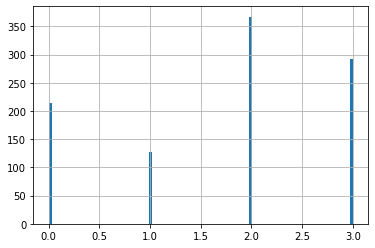

In [35]:
submit['accuracy_group'].hist(bins=100)
pass

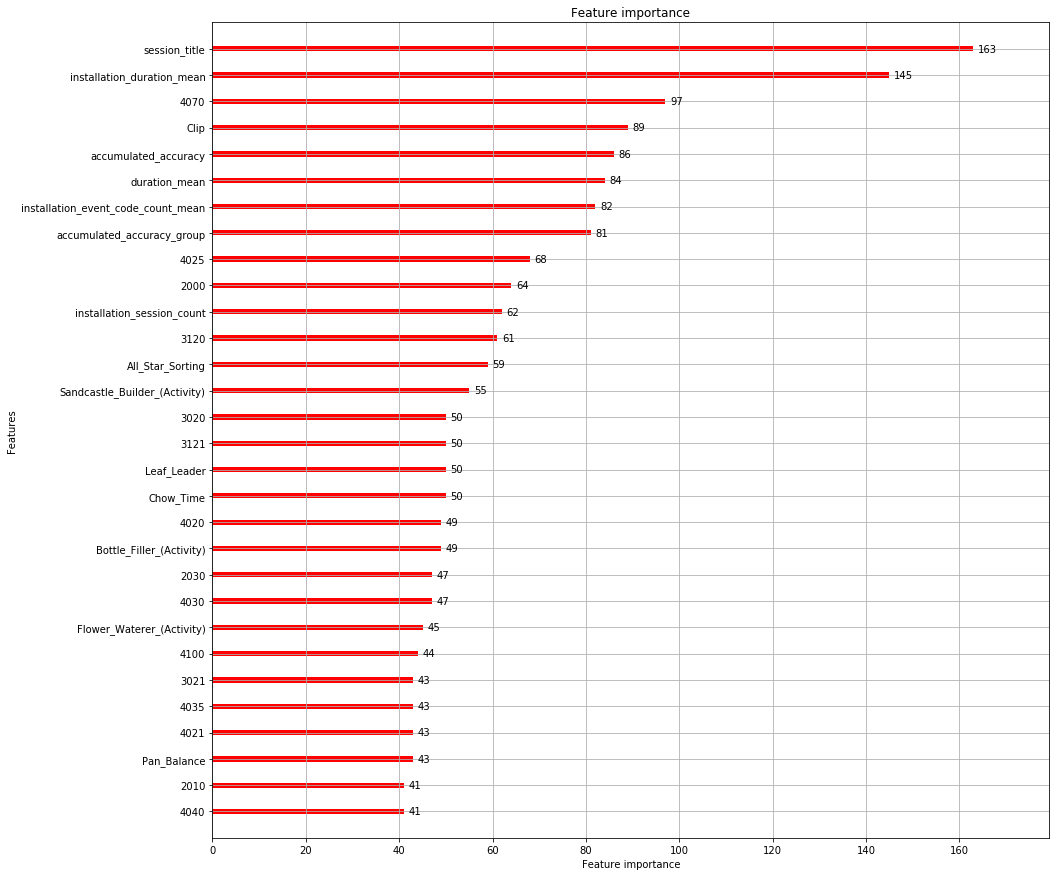

In [34]:
lgb.plot_importance(booster=model, figsize=(15,15), max_num_features=30, color='red')
pass

In [36]:
submit.to_csv('submission.csv', index=False)